*Luka Alhonen*
# Exercise 3

## 1 Non-programming Tasks

### 1.1 Learning diary

#### Characterising sensor performance

The measurements and the errors in these measurements provided by a sensors depend on two basic concepts; resolution and sampling interval. Resolution defines the amount of detectable variation or alteration while sampling interval determines the time difference between each successive sample. 

When measuring the performance of sensors, accuracy, variation and precision are the main concepts to observe. Accuracy determines how close to the true value a measurement is. Most commonly variation is used to measure the difference in precision between measurements, meaning how similar the measurements are.

Sensor measurements can also suffer from bias, which is defined as any systematic error in the measurements, which causes the accuracy of measurements to suffer. To correct bias (and other errors) sensors need to be adjusted, either using mechanical or software adjustment.


#### Handling Missing Data

Since datasets often contain missing data, methods for handling these missing data points are required for accurate analysis of data. Data may be missing from data sets due to sensor failure, inactive data collection tools or the lack of responses to surveys or questionnaires. Missing data can be placed into three different categories; Missing Completely At Random (MCAR), Missing At Random (MAR) and Missing Not At Random (MNAR).

Handling missing data is easiest when the data is MCAR or MAR, since MNAR data suggests and inherent bias in the data, which is best corrected with a new data collection method. 

The simplest method for handling missing data is to simply remove the missing records, however this is only effective if the number missing records is small. Instead of removing the missing data, the data can be substituted, which is referred to as Imputation. 


## 2 Programming Tasks

### 2.1 Measurements and Sampling

1. The average number of missing values for the whole dataset before imputation is 0.11513157894736842. After replacing the missing values with the mean of 'temperature' for each id the average number of missing values is 0.0.

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import numpy as np

In [136]:
df = pd.read_csv('measurements.csv')

In [137]:
# Get average number of nan values before imputation
print(df['temperature'].isna().mean())

0.11513157894736842


In [138]:
# Median case imputation
# For each id, get mean of temp and then replace nan with mean
for i in range(76):
    temp_mean = df.loc[df['id'] == i, 'temperature'].dropna().mean()
    df.loc[df['id'] == i, 'temperature'] =  df.loc[df['id'] == i, 'temperature'].fillna(temp_mean)

# Write df to .csv file
df.to_csv('measurements_imputated.csv')

In [139]:
# Get average number of nan values after imputation
print(df['temperature'].isna().mean())

0.0


2. Plot 1 highlights the outliers in the data after median case imputation. The average number of outliers is 3.0789473684210527

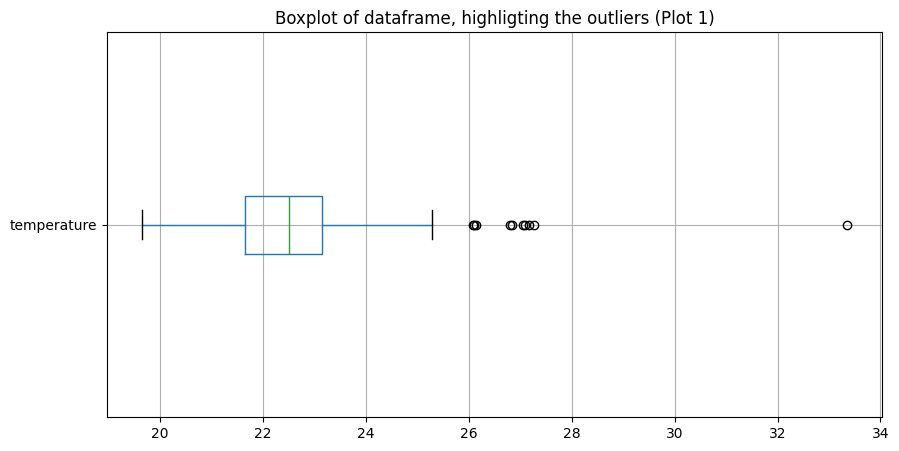

In [140]:
plt.figure(figsize=(10,5))
df.boxplot(column='temperature', vert=False)
plt.title('Boxplot of dataframe, highligting the outliers (Plot 1)')
plt.show()

In [141]:
# Calculate average number of outliers
grouped_df = df.groupby('id')
count_outliers = []
for _, id in grouped_df:
    Q1 = id['temperature'].quantile(0.25)
    Q3 = id['temperature'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = id[(id['temperature'] < (Q1 - 1.5 * IQR)) | (id['temperature'] > (Q3 + 1.5 * IQR))]['temperature']
    count_outliers.append(outliers.count())

avg_outliers = sum(count_outliers) / len(count_outliers)
print(f'Average number of outliers: {avg_outliers}')

Average number of outliers: 3.0789473684210527


3. After removing values outside of IQR and removing sensors with less than 61 values the number of remaining sensors is 41, which is further illustrated in plots 2.1 and 2.2

In [142]:
# Remove values outside of iqr and store resulting df in 'cleaned_df'
cleaned_df = pd.DataFrame()
for _, id in grouped_df:
    Q1 = id['temperature'].quantile(0.25)
    Q3 = id['temperature'].quantile(0.75)

    inside_iqr = id[(id['temperature'] >= Q1) & (id['temperature'] <= Q3)]
    cleaned_df = pd.concat([cleaned_df, inside_iqr])

# Remove sensors with less than 61 values
cleaned_df = cleaned_df.groupby('id').filter(lambda x: len(x) >= 61)
cleaned_df.to_csv('measurements_cleaned.csv') # for testing

print(f'Number of remaining sensors: {len(cleaned_df['id'].unique())}')

Number of remaining sensors: 41


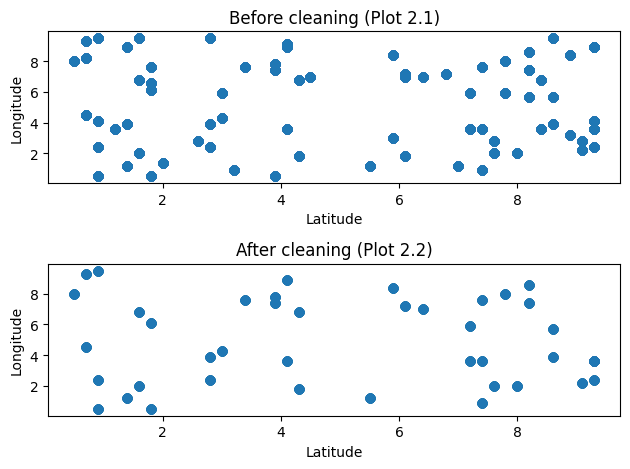

In [143]:
# Plot sensors before and after cleanup
fix, axs = plt.subplots(2)

axs[0].scatter(df['latitude'], df['longitude'])
axs[0].set_xlabel('Latitude')
axs[0].set_ylabel('Longitude')
axs[0].set_title('Before cleaning (Plot 2.1)')

axs[1].scatter(cleaned_df['latitude'], cleaned_df['longitude'])
axs[1].set_xlabel('Latitude')
axs[1].set_ylabel('Longitude')
axs[1].set_title('After cleaning (Plot 2.2)')

plt.tight_layout()
plt.show()

### 2.2 Preprocessing and Framing

a)

In [144]:
# read .wav file
fs, data = wavfile.read('rainforest.wav')

/var/folders/xm/g8279b9x4f9319__gr13r5zh0000gn/T/ipykernel_3533/2448137022.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('rainforest.wav')


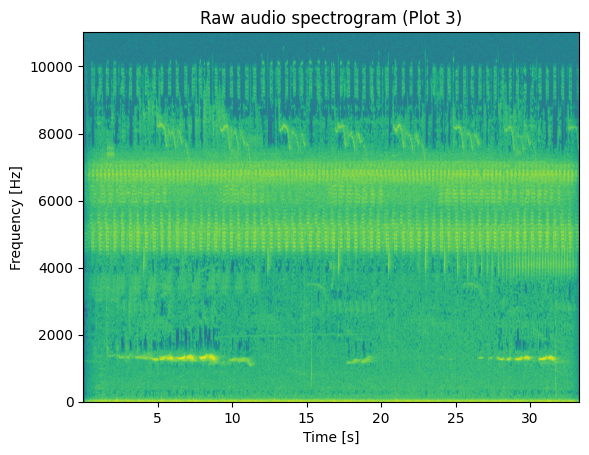

In [148]:
plt.specgram(data, Fs=fs, NFFT=1024, noverlap=512)
plt.title('Raw audio spectrogram (Plot 3)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

b) 

After some research and testing (by listening to the filtered signals) I found that the most appropriate frequency ranges for the sensors are 1000 Hz - 2000 Hz, for birdsong and 3000 Hz - 8000 Hz for crickets.

c)

For both birdsong and crickets the duty cycle should be roughly 50%

d)

In [146]:
bird_freq = [1000, 2000]
cricket_freq = [3000, 8000]

b_bird, a_bird = butter(5, bird_freq, btype='band', fs=fs)
b_cricket, a_cricket = butter(5, cricket_freq, btype='band', fs=fs)

bird_data = lfilter(b_bird, a_bird, data)
cricket_data = lfilter(b_cricket, a_cricket, data)

# Write filtered bird and cricket audio signals to .wav files, only for testing
wavfile.write('birds.wav', fs, bird_data.astype(np.int16))
wavfile.write('crickets.wav', fs, cricket_data.astype(np.int16))

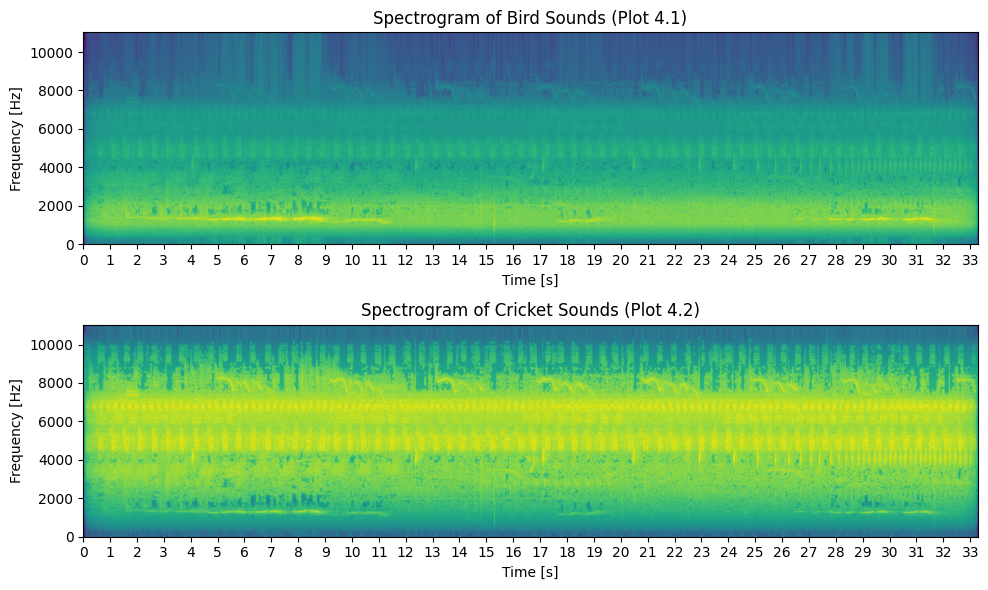

In [149]:
duration_bird = len(bird_data) / fs
duration_cricket = len(cricket_data) / fs

# Plot spectrograms

plt.figure(figsize=(10, 6))

# Plot the spectrogram for the bird audio signal
plt.subplot(2, 1, 1)
plt.specgram(bird_data, Fs=fs, NFFT=1024, noverlap=512)
plt.title('Spectrogram of Bird Sounds (Plot 4.1)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.xticks(np.arange(0, duration_bird, step=1))

# Plot the spectrogram for the cricket audio signal
plt.subplot(2, 1, 2)
plt.specgram(cricket_data, Fs=fs, NFFT=1024, noverlap=512)
plt.title('Spectrogram of Cricket Sounds (Plot 4.2)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.xticks(np.arange(0, duration_cricket, step=1))

plt.tight_layout()
plt.show()